In [25]:
'''

#Enable GPU for this Exercise.

'''

'\n\n#Enable GPU for this Exercise.\n\n'

In [26]:
import torch
import copy
import torch.nn as nn
from  torch.utils.data import random_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from skorch import NeuralNetClassifier

# This package is helpful to apply noise to our images
import skimage

#If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

'''
Import Mnist
'''
mnist = datasets.MNIST('./data', train=True, download=True, )
mnist_test = datasets.MNIST('./data', train=False, download=True, )
normal_test = (mnist_test.data.float()/255.).reshape(-1, 1, 28, 28)
normal_train = (mnist.data.float()/255.).reshape(-1, 1, 28, 28)
print(f"normal_train max: {normal_train.max()}, min: {normal_train.min()}")
normal_train = normal_train.float()
normal_test = normal_test.float()
X_train_GN = skimage.util.random_noise(normal_train, mode='gaussian', clip=True)
X_train_GN = torch.from_numpy(X_train_GN).float()
X_train_SP = skimage.util.random_noise(normal_train, mode='s&p', clip=True)
X_train_SP = torch.from_numpy(X_train_SP).float()   
X_valid_GN = skimage.util.random_noise(normal_test, mode='gaussian', clip=True)
X_valid_GN = torch.from_numpy(X_valid_GN).float()
X_valid_SP = skimage.util.random_noise(normal_test, mode='s&p', clip=True)
X_valid_SP = torch.from_numpy(X_valid_SP).float()    
print(f"train_GN max: {X_train_GN.max()}, min: {X_train_GN.min()}")
print(f"train_SP max: {X_train_SP.max()}, min: {X_train_SP.min()}")
pilimage = transforms.ToPILImage()
print(len(X_valid_SP))
print(len(normal_test))

device: cuda


normal_train max: 1.0, min: 0.0
train_GN max: 1.0, min: 0.0
train_SP max: 1.0, min: 0.0
10000
10000


/tmp/ipykernel_3151/1993720472.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


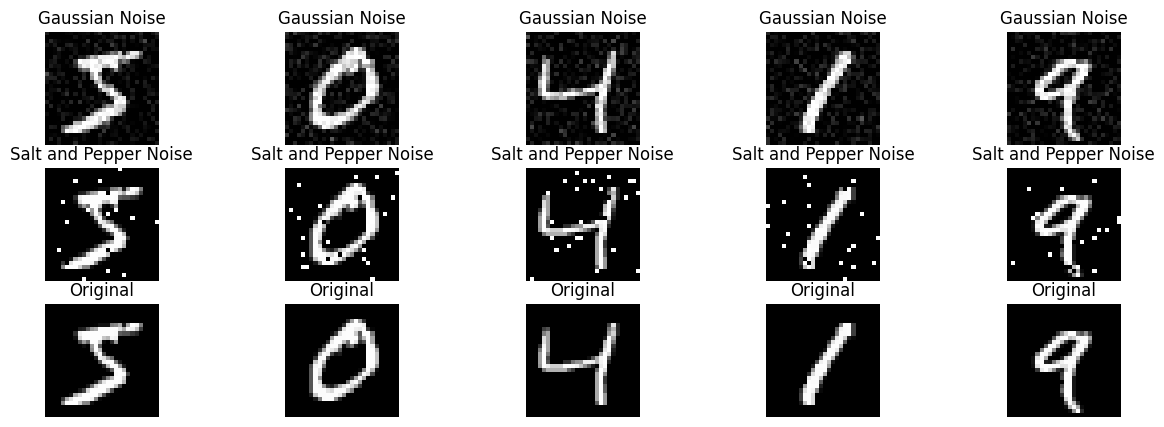

In [27]:
# get 5 images from both datasets
fig, ax = plt.subplots(3, 5, figsize=(15, 5))
for i in range(5):
    image_Gn = X_train_GN[i]
    image_Gn = image_Gn.squeeze(0)
    image_SP = X_train_SP[i]
    image_SP = image_SP.squeeze(0)
    # transform the image back to a PIL image, so we can plot it
    ax[0, i].imshow(image_Gn, cmap='gray')
    ax[0,i].set_title('Gaussian Noise')
    ax[0, i].axis('off')
    ax[1, i].imshow(image_SP, cmap='gray')
    ax[1, i].set_title('Salt and Pepper Noise')
    ax[1, i].axis('off')
    image_Gn_og = normal_train[i]
    image_Gn_og = image_Gn_og.squeeze(0)
    ax[2, i].imshow(image_Gn_og, cmap='gray')
    ax[2,i].set_title('Original')
    ax[2, i].axis('off')
fig.show() 


torch.Size([60000, 1, 28, 28])
img1: 1.0
img2: 1.0


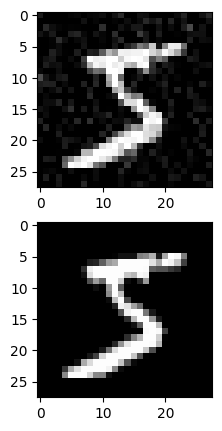

img1: 1.0
img2: 1.0


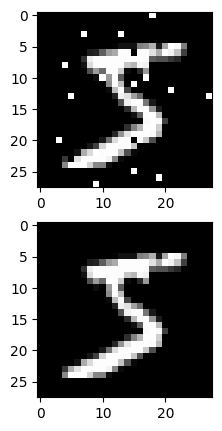

In [28]:
print(normal_train.shape)
train_GN_dataset = torch.utils.data.TensorDataset(X_train_GN, normal_train)
valid_GN_dataset = torch.utils.data.TensorDataset(X_valid_GN[:int(len(X_valid_GN)/2)], normal_test[:int(len(X_valid_GN)/2)])
train_SP_dataset = torch.utils.data.TensorDataset(X_train_SP, normal_train)
valid_SP_dataset = torch.utils.data.TensorDataset(X_valid_SP[:int(len(X_valid_SP)/2)], normal_test[:int(len(X_valid_SP)/2)])
img1, img2 = train_GN_dataset[0]
print(f"img1: {img1.max()}")
print(f"img2: {img2.max()}")
fig, ax = plt.subplots(2, figsize=(15, 5))
ax[0 ].imshow(img1.squeeze(0), cmap='gray')
ax[1].imshow(img2.squeeze(0), cmap='gray')
plt.show()
fig, ax = plt.subplots(2, figsize=(15, 5))
img1, img2 = train_SP_dataset[0]
print(f"img1: {img1.max()}")
print(f"img2: {img2.max()}")
ax[0].imshow(img1.squeeze(0), cmap='gray')
ax[1].imshow(img2.squeeze(0), cmap='gray')

In [29]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,5), bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
        )
        self.encoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=(5,5), bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
        )
        self.relu = nn.ReLU()

        # Linear layers
        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 4 * 4, 200),  
            nn.ReLU(),
            nn.Linear(200, 50),  
            nn.ReLU(),
            nn.Linear(50, 32*4*4),  
            nn.ReLU(),
            nn.Unflatten(1, (32, 4, 4))
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=5),
            nn.ReLU(),
            )
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=5),
            nn.ReLU()
        )

    def forward(self, x):
        x, indices1 = self.encoder(x)
        x, indices2 = self.encoder2(x)
        x = self.relu(x)
        x = self.linear_layers(x)
        x = self.unpool1(x, indices2)
        x = self.decoder(x)  # Reshape before passing to decoder
        x = self.unpool2(x, indices1)
        x = self.decoder2(x)
        return x

class MSElossForDebug(nn.Module):
    def __init__(self):
        super(MSElossForDebug, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, x, y):
        # print(f'x shape: {x.shape}')
        # print(f'y shape: {y.shape}')
        return self.mse(x, y)


In [31]:
import skorch
from skorch.helper import predefined_split
'''
Define your training routine,
your optimizer, your loss function.
Everything you need to train the model
'''
regSP = skorch.NeuralNetRegressor(
    module=ConvolutionalAutoencoder,
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    callbacks=[skorch.callbacks.EarlyStopping(patience=5), 
               skorch.callbacks.Checkpoint(monitor='valid_loss_best')],
    train_split=predefined_split(valid_SP_dataset),
    device=device,
    optimizer__lr=5e-6,
    # criterion__reduction='sum',
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__num_workers=2,  
    iterator_train__batch_size=64,
    iterator_valid__batch_size=64,
    max_epochs=100,
    )
inputs = train_SP_dataset[:][0]
targets = train_SP_dataset[:][1]
resSP = regSP.fit(inputs, y=targets)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0712        0.0472     +  9.2081
      2        0.0411        0.0335     +  9.5878
      3        0.0310        0.0265     +  10.4353
      4        0.0254        0.0225     +  11.1732
      5        0.0219        0.0196     +  11.6271
      6        0.0193        0.0175     +  10.1372
      7        0.0173        0.0158     +  9.5773
      8        0.0157        0.0144     +  9.9022
      9        0.0143        0.0132     +  10.6686
     10        0.0132        0.0122     +  10.9641
     11        0.0123        0.0114     +  10.4721
     12        0.0115        0.0107     +  11.0629
     13        0.0108        0.0101     +  11.3835
     14        0.0101        0.0095     +  11.4048
     15        0.0096        0.0090     +  11.2786
     16        0.0091        0.0086     +  9.9252
     17        0.0087        0.0082     +  9.9105
     18        0.0083        0.0078    

In [32]:
import numpy as np
def train(model, train, validate, optimizer, criterion, device, n_epochs=25):
    train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True )
    valid_loader = torch.utils.data.DataLoader(validate, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    model.train()
    training_loss = []
    validation_loss = []
    for i in range(n_epochs):
        epoch_training_loss = []
        epoch_validation_loss = []
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            # print(f'output shape: {output.shape}')
            # print(f'target shape: {target.shape}')
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_training_loss.append(loss.item())
        mean_epoch_training_loss = np.mean(epoch_training_loss)
        with torch.no_grad():
            model.eval()
            for data, target in valid_loader:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = criterion(output, target)
                epoch_validation_loss.append(loss.item())
        mean_valid_loss = np.mean(epoch_validation_loss)
        if i == n_epochs - 1:
            print(f"Final Training loss: {mean_epoch_training_loss: .4f}| Validation loss: {mean_valid_loss: .4f}")
        else:
            print(f"Epoch {i}| Training loss: {mean_epoch_training_loss: .4f}| Validation loss: {mean_valid_loss: .4f}")
        validation_loss.append(mean_valid_loss)
        training_loss.append(mean_epoch_training_loss)
    return 

In [33]:

AutonNN_SP = ConvolutionalAutoencoder().to(device)
train(AutonNN_SP, train_SP_dataset, valid_SP_dataset, torch.optim.Adam(AutonNN_SP.parameters(), lr=5e-6), nn.MSELoss(), device)

Epoch 0| Training loss:  0.0839| Validation loss:  0.0585
Epoch 1| Training loss:  0.0543| Validation loss:  0.0463
Epoch 2| Training loss:  0.0436| Validation loss:  0.0381
Epoch 3| Training loss:  0.0364| Validation loss:  0.0322
Epoch 4| Training loss:  0.0312| Validation loss:  0.0280
Epoch 5| Training loss:  0.0274| Validation loss:  0.0249
Epoch 6| Training loss:  0.0246| Validation loss:  0.0225
Epoch 7| Training loss:  0.0224| Validation loss:  0.0207
Epoch 8| Training loss:  0.0207| Validation loss:  0.0193
Epoch 9| Training loss:  0.0192| Validation loss:  0.0177
Epoch 10| Training loss:  0.0178| Validation loss:  0.0166
Epoch 11| Training loss:  0.0167| Validation loss:  0.0155
Epoch 12| Training loss:  0.0157| Validation loss:  0.0146
Epoch 13| Training loss:  0.0148| Validation loss:  0.0138
Epoch 14| Training loss:  0.0140| Validation loss:  0.0131
Epoch 15| Training loss:  0.0133| Validation loss:  0.0124
Epoch 16| Training loss:  0.0127| Validation loss:  0.0119
Epoch 1

TypeError: cannot unpack non-iterable NoneType object

In [34]:

def plot_images(og_images, transformed_images ,n_cols=10):
    fig, ax = plt.subplots(2, n_cols, figsize=(15, 5))
    for i in range(n_cols):
        ogimg = og_images[i].squeeze(0)
        ogimg = pilimage(ogimg)
        ax[0, i].imshow(ogimg, cmap='gray')
        ax[0, i].axis('off')
        ax[0, i].set_title('Original')
        trsimg = transformed_images[i].squeeze(0)
        trsimg = pilimage(trsimg)
        ax[1, i].imshow(trsimg, cmap='gray')
        ax[1, i].axis('off')
        ax[1, i].set_title('Transformed')
    plt.show()

(10, 1, 28, 28)
Test loss is  0.0042


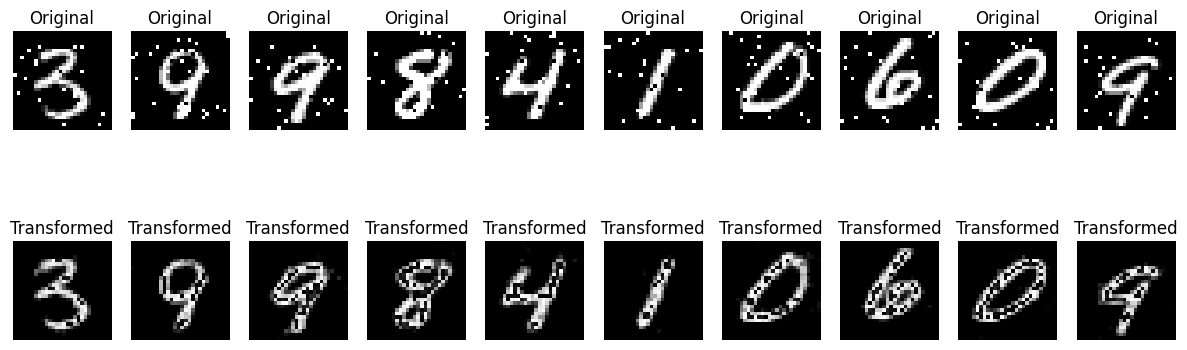

In [47]:
test10 = X_valid_SP[int(len(X_valid_SP)/2):int(len(X_valid_SP)/2)+10]
# print(test10[0][0].shape)
test10 = test10.float()

imgs10 = resSP.predict(test10)
criterion = nn.MSELoss()
print(imgs10.shape)
imgs10 = torch.from_numpy(imgs10).float()
original_10 = normal_test[int(len(normal_test)/2):int(len(normal_test)/2)+10]
original_10 = original_10.float()
print(f"Test loss is {criterion(imgs10, original_10).item(): .4f}")
# print(imgs10[0].shape) 
# get 5 images from both datasets
plot_images(test10, imgs10, 10)
# train_pred_5 = resSP.predict(train_SP_5)
# plot_images(train_SP_5, train_pred_5, 5)


Test loss:  0.0094
torch.Size([10, 1, 28, 28])


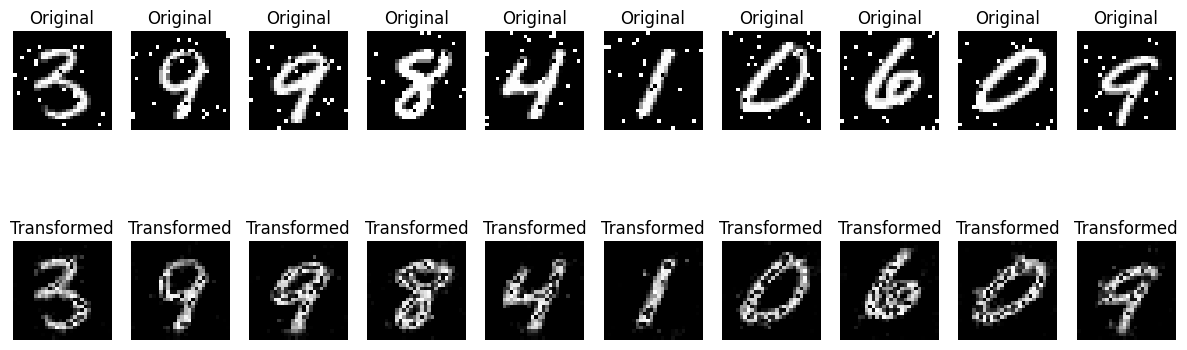

In [44]:

test10 = X_valid_SP[int(len(X_valid_SP)/2):int(len(X_valid_SP)/2)+10]
test10 = test10.to(device)
# print(test10[0][0].shape)
AutonNN_SP.eval()

criterion = nn.MSELoss()
imgs10 = AutonNN_SP(test10)
original_10 = normal_test[int(len(normal_test)/2):int(len(normal_test)/2)+10]
original_10 = original_10.float().to(device)
print(f"Test loss: {criterion(imgs10, original_10).item(): .4f}")
print(imgs10.shape)
plot_images(test10, imgs10, 10)

In [39]:
# define the netowrk to be train with the gaussian corrupted images
# train the network 
AutoNN_GN = ConvolutionalAutoencoder().to(device)
train(AutoNN_GN, train_GN_dataset, valid_GN_dataset, torch.optim.Adam(AutoNN_GN.parameters(), lr=1e-3), nn.MSELoss(), device)

Epoch 0| Training loss:  0.0114| Validation loss:  0.0039
Epoch 1| Training loss:  0.0034| Validation loss:  0.0030
Epoch 2| Training loss:  0.0029| Validation loss:  0.0027
Epoch 3| Training loss:  0.0026| Validation loss:  0.0024
Epoch 4| Training loss:  0.0025| Validation loss:  0.0023
Epoch 5| Training loss:  0.0023| Validation loss:  0.0023
Epoch 6| Training loss:  0.0023| Validation loss:  0.0022
Epoch 7| Training loss:  0.0022| Validation loss:  0.0021
Epoch 8| Training loss:  0.0021| Validation loss:  0.0021
Epoch 9| Training loss:  0.0021| Validation loss:  0.0021
Epoch 10| Training loss:  0.0021| Validation loss:  0.0020
Epoch 11| Training loss:  0.0021| Validation loss:  0.0020
Epoch 12| Training loss:  0.0020| Validation loss:  0.0020
Epoch 13| Training loss:  0.0020| Validation loss:  0.0019
Epoch 14| Training loss:  0.0020| Validation loss:  0.0019
Epoch 15| Training loss:  0.0020| Validation loss:  0.0019
Epoch 16| Training loss:  0.0020| Validation loss:  0.0019
Epoch 1

0.0019109116401523352
torch.Size([10, 1, 28, 28])


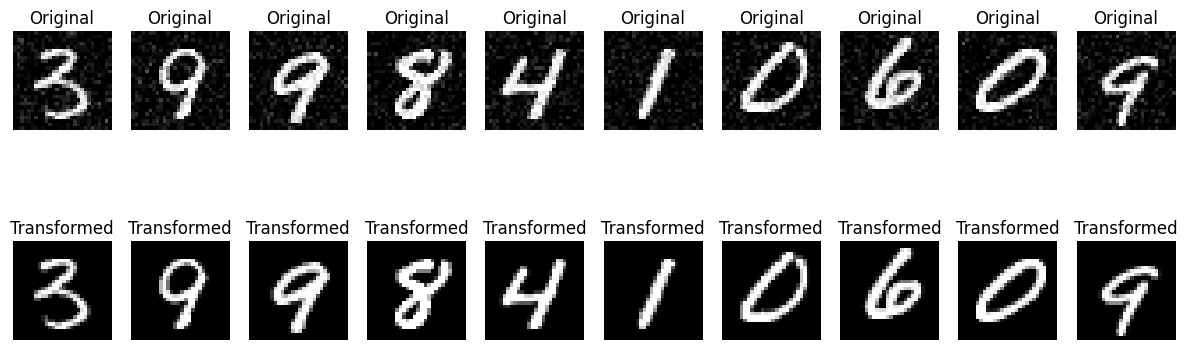

In [43]:
# get decoded images from test
test10 = X_valid_GN[int(len(X_valid_GN)/2):int(len(X_valid_GN)/2)+10]
test10 = test10.float().to(device)
# print(test10[0][0].shape)
AutoNN_GN.eval()
criterion = nn.MSELoss()

imgs10 = AutoNN_GN(test10)
original_10 = normal_test[int(len(normal_test)/2):int(len(normal_test)/2)+10]
original_10 = original_10.float().to(device)
print(criterion(imgs10, original_10).item())
print(imgs10.shape)
plot_images(test10, original_10, 10)

In [ ]:
# corrupt test images with Gaussian noise, pass them through AutoNN_GN
# plot the results 